In [1]:
import os 
import pickle
import numpy as np
import astropy.table as atable
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# read in exposures outputed from desisurvey run
fsurveysim = os.path.join(os.environ['CSCRATCH'], 'desisurvey_output', 'exposures_280s_bgs14000_skybranch_v8.brightsky.fits')
exposures = fits.getdata(fsurveysim, 'exposures')

# get observing conditions of BGS exposures calculated from TILE position and MJD output
isbgs = pickle.load(open(fsurveysim.replace('.fits', '.is_bgs.p'), 'rb'))

In [3]:
fsky = 'sv1.bright_exps.20210217.Isky.npy'
fwave = 'sv1.bright_exps.20210217.wave.npy'
fobscond = 'sv1.bright_exps.20210217.obs_cond.hdf5'

bright_exps = atable.Table.read(fobscond, format='hdf5')
Iskies = np.load(fsky)
wave = np.load(fwave)
    
# observing conditions from median value of the GFAs
sv1_airmass = bright_exps['AIRMASS']
sv1_moon_frac = bright_exps['MOON_ILLUMINATION']
sv1_moon_sep = bright_exps['MOON_SEP_DEG']
sv1_moon_alt = 90. - bright_exps['MOON_ZD_DEG']
sv1_transp = bright_exps['TRANSPARENCY']

In [5]:
from scipy.ndimage import gaussian_filter1d
def smooth_sky(sky, smoothing=100.): 
    return gaussian_filter1d(sky, smoothing) 

Isky5000_sv1 = np.array([np.interp(5000, wave, smooth_sky(Isky)) for Isky in Iskies])

[]

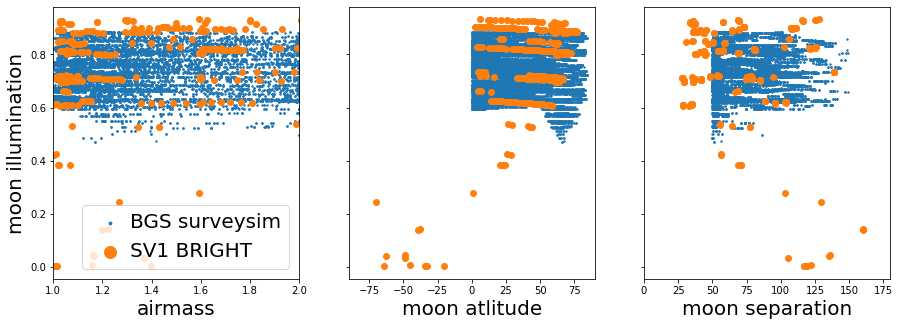

In [6]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(exposures['AIRMASS'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2, label='BGS surveysim')
sub.scatter(sv1_airmass, sv1_moon_frac, c='C1', label='SV1 BRIGHT')
sub.legend(loc='lower right', fontsize=20, handletextpad=0, markerscale=2)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(exposures['MOON_ALT'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2)
sub.scatter(sv1_moon_alt, sv1_moon_frac, c='C1')
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(exposures['MOON_SEP'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2)
sub.scatter(sv1_moon_sep, sv1_moon_frac, c='C1')
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

In [7]:
from itertools import chain, combinations_with_replacement
def bright_Isky5000_regression(airmass, moon_frac, moon_sep, moon_alt):
    ''' polynomial regression model for bright sky surface brightness at 5000A
    *without twilight*. The regression model was fit using observed sky surface
    brightnesses from DESI SV1, DESI CMX, and BOSS.

    see
    https://github.com/desi-bgs/bgs-cmxsv/blob/4c5f124164b649c595cd2dca87d14ba9f3b2c64d/doc/nb/sv1_sky_model_fit.ipynb
    for detials.
    '''
    # polynomial regression cofficients for estimating exposure time factor during
    # non-twilight from airmass, moon_frac, moon_sep, moon_alt
    coeffs = np.array([
        1.11964670e+00,  1.89072762e-01,  3.20306279e+00,  4.10688340e-02,
       -2.66073069e-02, -5.44857514e-01,  4.15680599e+00,  1.75625108e-02,
       -5.01143360e-03,  1.30579080e+00,  6.17225096e-02, -1.07765709e-01,
       -7.23089844e-04, -5.42455907e-04,  6.32035728e-04])

    theta = np.atleast_2d(np.array([airmass, moon_frac, moon_alt, moon_sep]).T)

    combs = chain.from_iterable(combinations_with_replacement(range(4), i) for i in range(0, 3))

    theta_transform = np.empty((theta.shape[0], len(coeffs)))
    for i, comb in enumerate(combs):
        theta_transform[:, i] = theta[:, comb].prod(1)

    return np.dot(theta_transform, coeffs.T)

Isky5000_surveysim = bright_Isky5000_regression(exposures['AIRMASS'][isbgs], exposures['MOON_ILL'][isbgs], exposures['MOON_SEP'][isbgs], exposures['MOON_ALT'][isbgs])

In [8]:
import desisim.simexp
import specsim.instrument
from desimodel.io import load_throughput

# get nominal dark sky surface brightness
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
_wave = np.arange(round(wavemin, 1), wavemax, 0.8)
config = desisim.simexp._specsim_config_for_wave(_wave, dwave_out=0.8, specsim_config_file='desi')

sb_dict     = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark'] # nominal dark sky

Isky5000_dark = np.interp(5000, _wave, smooth_sky(Isky_dark))

In [9]:
not_actually_bright = (Isky5000_surveysim / Isky5000_dark < 2.5)
print('%i of %i exposures are <2.5x dark sky' % (np.sum(not_actually_bright), len(not_actually_bright)))
print('%.3f percent' % (np.sum(not_actually_bright)/len(not_actually_bright)*100.))

1457 of 12794 exposures are <2.5x dark sky
11.388 percent


[]

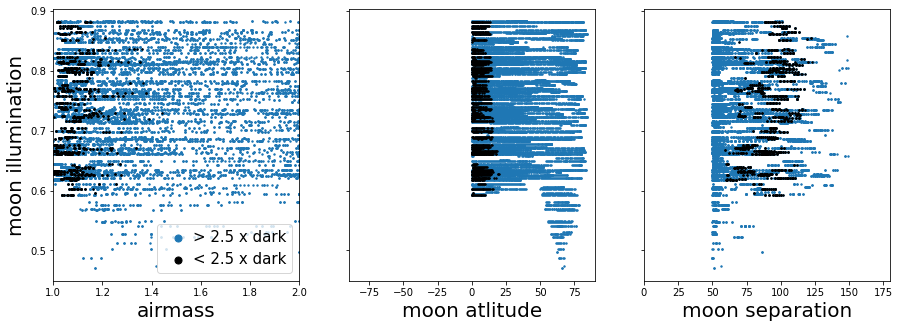

In [10]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(131)
sub.scatter(exposures['AIRMASS'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2, label='> 2.5 x dark')
sub.scatter(exposures['AIRMASS'][isbgs][not_actually_bright], exposures['MOON_ILL'][isbgs][not_actually_bright], c='k', s=2, label='< 2.5 x dark')

sub.legend(loc='lower right', fontsize=15, handletextpad=0, markerscale=5)
sub.set_xlabel('airmass', fontsize=20)
sub.set_xlim(1., 2.)
sub.set_ylabel('moon illumination', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(exposures['MOON_ALT'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2)
sub.scatter(exposures['MOON_ALT'][isbgs][not_actually_bright], exposures['MOON_ILL'][isbgs][not_actually_bright], c='k', s=2)
sub.set_xlabel('moon atlitude', fontsize=20)
sub.set_xlim(-90., 90.)
sub.set_yticklabels([])

sub = fig.add_subplot(133)
sub.scatter(exposures['MOON_SEP'][isbgs], exposures['MOON_ILL'][isbgs], c='C0', s=2)
sub.scatter(exposures['MOON_SEP'][isbgs][not_actually_bright], exposures['MOON_ILL'][isbgs][not_actually_bright], c='k', s=2)
sub.set_xlabel('moon separation', fontsize=20)
sub.set_xlim(0., 180.)
sub.set_yticklabels([])

Text(0.5, 0, 'sky surface brightness')

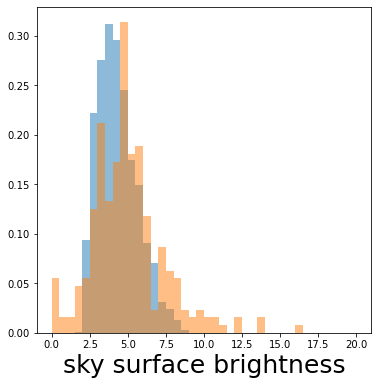

In [11]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.hist(Isky5000_surveysim, range=(0., 20), bins=40, density=True, alpha=0.5)
sub.hist(Isky5000_sv1, range=(0., 20.), bins=40, density=True, alpha=0.5)
sub.set_xlabel('sky surface brightness', fontsize=25)